# MyND Offline Processing: Data Analysis
Author: Geeling Chau<br> 
Description: Process xdf files recorded from experimental sessions to determine file eligibility and data feature extraction.<br>
Sources: 
- Ollie's Segment Speller Offline Processing Code https://github.com/ollie-d/SegSpeller/blob/master/Offline%20Processing.ipynb 
- neurodsp https://github.com/neurodsp-tools/neurodsp


## Imports

In [3]:
from helperFunctions import *
from constants import *
import copy
import time

import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [4]:
def findLargestStdev(component, verbose=True):
    max_i = 0
    max_val = 0
    for i in range(4): 
        filtered_sig = filterEEG(component[:,i], eeg_fs, (1, 5))
        std_val = np.std(filtered_sig)
        if (verbose) :
            plt.plot(filtered_sig, label=str(i) + " " + str(std_val))
        if std_val > max_val : 
            max_i = i
            max_val = std_val
    
    if (verbose) :
        plt.legend()
        plt.title("filtered signals to find blinks")
        plt.show()
    return max_i

In [5]:
def getCleanedSignal(original_data, verbose=True):
    active_eeg = original_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())]
    eeg_time = original_data[StreamType.EEG.value][StreamType.TIME.value]

    if(verbose) : 
        line_objects = plt.plot(eeg_time, active_eeg)
        plt.legend(iter(line_objects), list(channels.keys()))
        plt.title("EEG of 2 Eye Blinks")
        plt.show()

    ica = FastICA(n_components=4)
    standardized=active_eeg
    standardized /= active_eeg.std(axis=0)
    
    S = ica.fit_transform(active_eeg)  # Reconstruct signals
    
    if(verbose):
        line_objects = plt.plot(eeg_time, S)
        plt.legend(iter(line_objects), list(range(len(line_objects))))
        plt.title("ICA Decomposition of EEG")
        plt.show()

    # Get the component with the largest standard deviation after being filtered to 1-10Hz
    max_i = findLargestStdev(S, verbose=verbose)
    
    remove_indices = [max_i]  # pretend the user selected components 0, 1, and 3
    
    cleaned_components = copy.deepcopy(S)
    # "remove" unwanted components by setting them to 0 - simplistic but gets the job done
    cleaned_components[:, remove_indices] = 0
    
    #reconstruct signal
    X_restored = ica.inverse_transform(cleaned_components)
    
    filtered_cleaned_data = copy.deepcopy(original_data)
    i = 0
    for channel in channels: 
        filtered_cleaned_data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]] = X_restored[:,i]
        i += 1
        
    if(verbose):
        line_objects = plt.plot(eeg_time, X_restored)
        plt.legend(iter(line_objects), list(channels.keys()))
        plt.title("EEG without blinks")
        plt.show()
    
    return filtered_cleaned_data
    

In [6]:
def filterStreamStructEEG(original_data):
    filtered_data = copy.deepcopy(original_data)
    for channel in channels :
        eeg_data = XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]]
        sig_filt = filterEEG(eeg_data, eeg_fs)
        filtered_data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]] = sig_filt

    return filtered_data

## Main

### Get Data

In [7]:
'''
Files that work with this notebook: 
participant_P004_exp001_block_full_start.xdf # full start
participant_P004_exp002_block_full_start.xdf # This should work: after restarting computer
participant_P004_exp003_block_full_start.xdf # This should work too
participant_P004_exp001_block_full_short.xdf # Works
participant_P004_exp001_block_full_long.xdf # Works

'''

XDF_Data = loadxdf("../data/P004/participant_P004_exp001_block_full_short.xdf")
if StreamType.EEG.value in XDF_Data : 
    eeg_fs = int(XDF_Data[StreamType.EEG.value][StreamType.FS.value])
    print("eeg_fs = ", eeg_fs)
if StreamType.EYE.value in XDF_Data : 
    time_differences_eye_tracker = [XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE][i+1]-XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE][i] for i in range(len(XDF_Data[EYE_STREAM_TYPE][TIME_STREAM_TYPE])-1)]
    mean_fs_eye_tracker = 1/np.mean(time_differences_eye_tracker)
    eye_fs = int(mean_fs_eye_tracker)
    print("eye_fs = ", eye_fs)
# Trim the data to only include the time PsychoPy was running
XDF_Data = epochByMarkIndex(0, -1, XDF_Data)

markers = np.array(XDF_Data[MARKER_STREAM_TYPE][DATA_STREAM_TYPE][:,0])
marker_indexes = {}
for index, marker in enumerate(markers): 
    marker_indexes[marker] = index
    


eeg_fs =  250
eye_fs =  37


In [8]:
# Recording data checks (whether all markers are there etc)
markersFound = True
for marker_key in PSYCHO_PY_MARKERS : 
    if PSYCHO_PY_MARKERS[marker_key] not in markers: 
        markersFound = False 
        print("Missing Marker:", PSYCHO_PY_MARKERS[marker_key])
print("All Markers Found?", markersFound)


Missing Marker: --InstructionStart
Missing Marker: --InstructionStop
Missing Marker: --LettersShown
All Markers Found? False


## Filtering

### Filter 1-50 Hz

In [9]:
filtered_data = filterStreamStructEEG(XDF_Data)

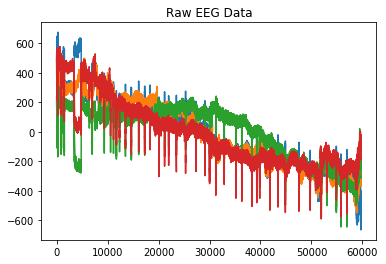

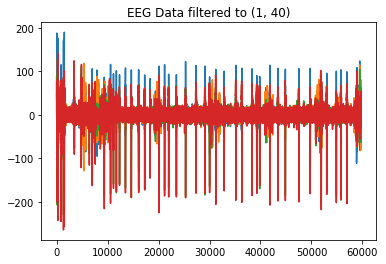

In [10]:
# Check filtering
for channel in channels: 
    eeg_data = XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]]
    plt.plot(eeg_data)
plt.title("Raw EEG Data")
plt.show()

for channel in channels: 
    eeg_data = filtered_data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]]
    plt.plot(eeg_data)
plt.title("EEG Data filtered to " + str(f_range))
plt.show()

## Clean artifacts from VEOG

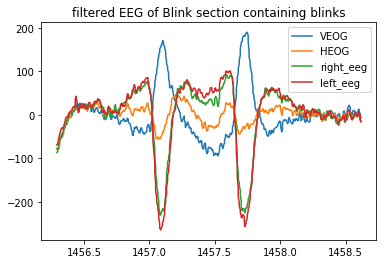

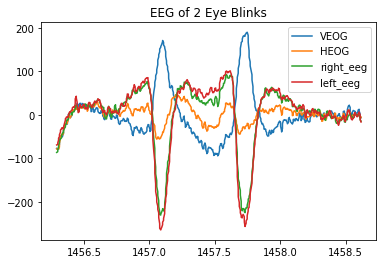

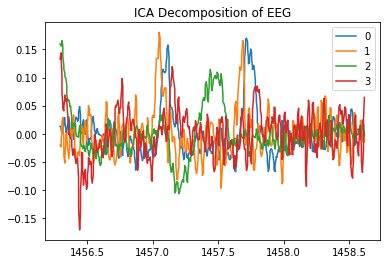

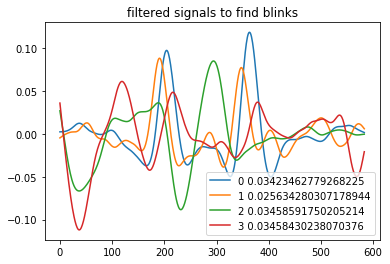

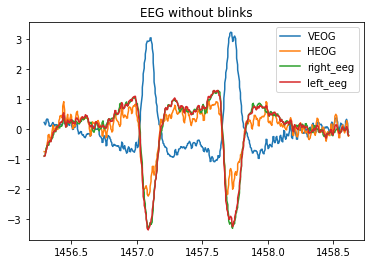

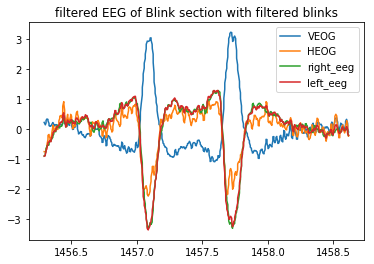

In [11]:
# Filter only the blink data
new_data, a, b = getMarkerBoundSingleMarkerData(blinkText, "--SpacePressed", original_data=filtered_data)
blink_data=new_data[0]

# Show original blink data
line_objects = plt.plot(blink_data[StreamType.EEG.value][StreamType.TIME.value], blink_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())])
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("filtered EEG of Blink section containing blinks")
plt.show()

# Filter out the blink component
filtered_cleaned_blink_data  = getCleanedSignal(blink_data, verbose=True)

# Show the data without the blink component
plt.plot(filtered_cleaned_blink_data[StreamType.EEG.value][StreamType.TIME.value], filtered_cleaned_blink_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())])
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("filtered EEG of Blink section with filtered blinks")
plt.show()



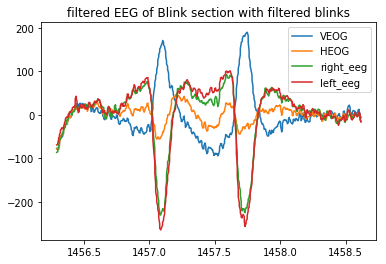

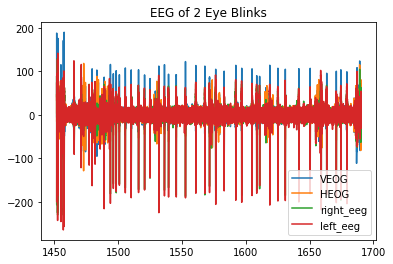

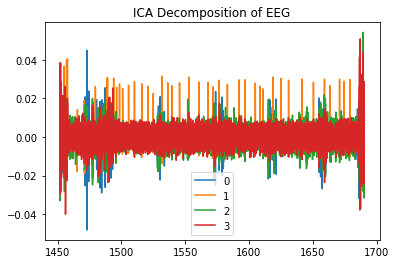

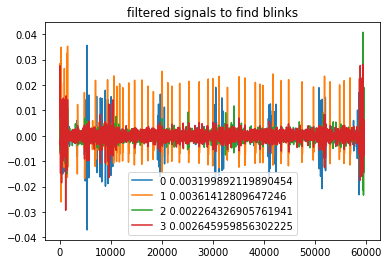

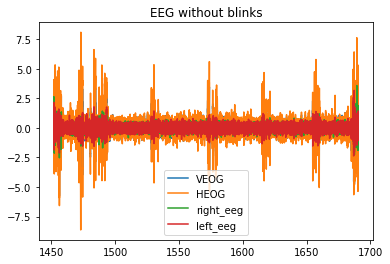

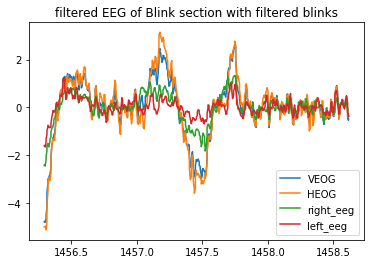

In [12]:
#Filter the entire EEG data

# Show original blink data
new_data, a, b = getMarkerBoundSingleMarkerData(blinkText, "--SpacePressed", original_data=filtered_data)
blink_data=new_data[0]

plt.plot(blink_data[StreamType.EEG.value][StreamType.TIME.value], blink_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())])
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("filtered EEG of Blink section with filtered blinks")
plt.show()

#Filter the entire EEG data
filtered_cleaned_data  = getCleanedSignal(filtered_data, verbose=True)


# Show the cleaned data at the blink section
new_data, a, b = getMarkerBoundSingleMarkerData(blinkText, "--SpacePressed", original_data=filtered_cleaned_data)
blink_data = new_data[0]

plt.plot(blink_data[StreamType.EEG.value][StreamType.TIME.value], blink_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())])
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("filtered EEG of Blink section with filtered blinks")
plt.show()


## Get points for each section

In [13]:
# Get sections
numSections = getNumSections(filtered_cleaned_data)
article_sections = list()
for i in range(numSections) : 
    article_sections.append(getArticleSectionData("response", i, filtered_cleaned_data))


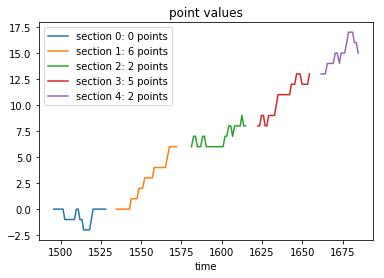

In [14]:
for i, article_section in enumerate(article_sections):
    data, time = getPointsAfterEachWord(article_section)
    num_delta_points = getTotalPoints(article_section)
    plt.plot(time[:], data[:], label="section " + str(i) + ": " + str(num_delta_points) + " points")
plt.title("point values")
plt.xlabel("time")
plt.legend()
plt.show()

## Get power for each section (in progress)

In [15]:
import pyeeg

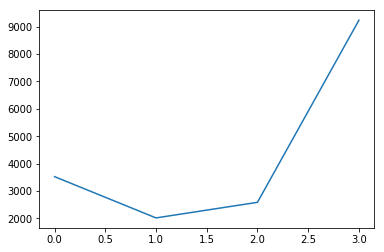

In [19]:
power, power_ratio = pyeeg.bin_power(article_section[StreamType.EEG.value][StreamType.DATA.value][:,channels['right_eeg']], [0.5,4,7,12,30], eeg_fs)

plt.plot(power)